In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import time  

In [90]:
training_path = r"C:\Users\prake\ass2\fmnist_train.csv"
test_path = r"C:\Users\prake\ass2\fmnist_test.csv"

In [91]:
#function to read the data and convert into numpy arrays
def read_data(file_path):
    train_data = np.array(pd.read_csv(file_path, header=None))
    x_train = train_data[:,0:784]
    y_train = train_data[:,784:785]
    y_train = y_train.reshape(len(y_train),)
    
    return x_train,y_train

# Neural network construction using forward, bakcward propogation 

In [92]:
#function to convert labels into one hot encoding form
def one_hot_encoding(y_label):
    labels = np.zeros((len(y_label),len(np.unique(y_label))))
    rows = np.arange(y_label.size)
    labels[rows,y_label] = 1
    return labels

In [93]:
#get the data 
x_train,y_train = read_data(training_path)
X_train = x_train
X_train = (X_train*1.0)/255
Y_train = one_hot_encoding(y_train)
# Y = y_train
print('Shape of X :',X_train.shape)
print('Shape of Y :',Y_train.shape)


Shape of X : (60000, 784)
Shape of Y : (60000, 10)


In [94]:
#data pre-processing
test_x, test_y = read_data(test_path)
X_test = (test_x*1.0)/255
Y_test = one_hot_encoding(test_y)
print('Shape of X :',X_test.shape)
print('Shape of Y :',Y_test.shape)

Shape of X : (10000, 784)
Shape of Y : (10000, 10)


In [95]:
def mse(labels, predictions): #mean square error  1/n(sum of (y-y')^2)
    diff = np.subtract(labels, predictions)
    sq_diff = np.square(diff)
    err_vector = np.sum(sq_diff,axis=1)/2
    sum_vector = np.sum(err_vector)
    error = (sum_vector*1.0)/sum_vector.size
    return error

In [96]:
def activation_fn(z,af,deriv=False):
    if af == 'sigmoid':
        if deriv == True:
            return np.multiply(z,1-z)
        else:
            return 1/(1 + np.exp(-z))
    if af == 'relu':
        if deriv == True:
            return (z>0)*1
        else:
            input_rows = z
            for r in input_rows:
                r[r < 0] = 0
            return input_rows   

In [97]:
def define_layers(nodes_hidden, total_features, total_classes,batch_size,initial_weight):
    
    layers = []
    first_layer = 0
    no_layers = len(nodes_hidden)    
    
    #first hidden layer with neurons = total_features + 1
    for i in range(no_layers+1):
        layer = {}
        if first_layer == 0:
            no_weights = total_features+1
            first_layer +=1
        else :
            no_weights = nodes_hidden[i-1]+1
        
        if i == no_layers :
            no_neurons = total_classes
        else :
            no_neurons = nodes_hidden[i]
        
        layer["node_count"] = no_neurons
        layer["weights"] = np.random.uniform(-initial_weight, initial_weight, size=(no_neurons, no_weights))
        layer["net_input"] = np.zeros((batch_size,no_weights))
        print('layer no :',i,'No of neurons :',no_neurons,'No of weights :',no_weights,layer["weights"].shape)
        layers.append(layer)
    
    return layers

In [98]:
def forward_prop(input_data, af, layers, batch_size):
    
    total_layers = len(layers) #no. of layers in the network
    
    #set x0 =1 for bias 
    bias_ones = np.ones(input_data.shape[0])
    #concate 1's to input data 
    input_data = np.c_[bias_ones,input_data]
    layers[0]["net_input"] = input_data #we copy whole batch to net_input
    tot_lay = total_layers-1
    
    #iterate through all the layers 
    for i in range(tot_lay): 
        ith_layer_weight = layers[i]["weights"]
        ith_layer_net_input = layers[i]["net_input"].T
        
        net_input = np.dot(ith_layer_weight,ith_layer_net_input)
        # W*X.T + b
        
        net_input = activation_fn(net_input,af)
        
        #set x0=1 for next_net_input
        layers[i+1]["net_input"] = net_input.T
        #it will be input for next layer
        ones_shape = layers[i+1]["net_input"]
        #one's are added to next layer input
        i_plus_layer_ones = np.ones(ones_shape.shape[0])
        layers[i+1]["net_input"] = np.c_[i_plus_layer_ones,ones_shape]

In [99]:
def back_prop(labels, predictions, last_layer, layers, lr, af, net):
#δL =1/M (Yb − Ol)Ol(1 − Ol)
#δl = δl+1θlOl(1 − Ol)
    batch_size = predictions.shape[0]
    
    derv = predictions*(1-predictions) #multiply element by element
    difference = labels - predictions
    delta_L = np.multiply(difference, derv)
    delta_trans = delta_L.T
    last_lay_inp = layers[last_layer]["net_input"]
    delta_w = np.dot(delta_trans,last_lay_inp )
    #net_input is the output of the previous layer
    last_lay_weight = layers[last_layer]["weights"] 
    learn_rate_delta_w = lr * delta_w
    divr = learn_rate_delta_w/batch_size
    
    #back propagation in hidden layers
    n = last_layer-1
    
    updated_weights = last_lay_weight + divr
    # the update rule θt+1 = θt + αXlδl+1
    for i in range(n , -1, -1):
        
        y = layers[i+1]["net_input"]
        
        derv = activation_fn(y,af,deriv=True)
        
        layers[i+1]["weights"] = updated_weights
        
        i_plus_lay_weights = layers[i+1]["weights"][:,1:]
        
        temp = np.dot(delta_L , i_plus_lay_weights)
          
        delta_L = np.multiply(temp, derv[:,1:])
        i_lay_weights = layers[i]["net_input"]
        delta_w = np.dot(delta_L.T , i_lay_weights)
        
        i_lay_weight = layers[i]["weights"]
        lr_delta = lr * delta_w
            
        updated_weights = i_lay_weight + (lr_delta/batch_size)
    layers[0]["weights"] = updated_weights

In [100]:
def train_per_batch(layers, features, labels, af, lr, nt):
    #features is a subset of x
    #labels is subset of y
    batch_size = 100
    forward_prop(features, af, layers, batch_size) #forward propagation
    
    #get the prediction of output layer
    last_layer = len(layers) - 1
    last_layer_input = layers[last_layer]["net_input"]
    last_layer_weight = layers[last_layer]["weights"].T
    z = np.dot(last_layer_input,last_layer_weight)
    
# predictions = sigmoid(z)
    predictions = activation_fn(z,'sigmoid')
    #output of lastlayer
    #compute mean squared error
    error = mse(labels, predictions)
    #back propagate the error to update weights
    back_prop(labels, predictions, last_layer, layers, lr, af,batch_size )
    
    return error

In [101]:
def accuracy_(layers, features, labels, af):
    
    batch_size = 100
    forward_prop(features, af, layers,batch_size)
    
    #get the prediction
    last_layer = len(layers) - 1
    
    last_layer_inp = layers[last_layer]["net_input"]
    last_layer_weight = layers[last_layer]["weights"].T
    mult = np.dot(last_layer_inp, last_layer_weight)
    predictions = activation_fn(mult,'sigmoid')
    
    total_count = len(predictions)
    
    for i in range(0,total_count):  
        
        maximum_val = np.max(predictions[i])
        true_val = predictions[i] >= maximum_val
        predictions[i] = true_val.astype(int)

    print('No of total values Match :',total_count)
    crct_result = np.all(labels == predictions, axis=1)
    print('number of correct match :',np.sum(crct_result))
    correct_count = np.sum(crct_result)
    
    accuracy = (correct_count*100.0)/total_count
    print("Accuracy: ", accuracy)
    return round(accuracy,2)

In [102]:
def plot_test_acc(title,X_label,Y_label,X_Axis,test_accuracies,training_accuracies):
  if len(test_accuracies) != 1:
    plt.plot(X_Axis, test_accuracies, color='g',label="Test Accuracy")
    plt.scatter(X_Axis,test_accuracies)
  plt.plot(X_Axis, training_accuracies, color='orange',label="Training Accuracy")
  plt.scatter(X_Axis,training_accuracies)
  plt.xlabel(X_label)
  plt.ylabel(Y_label)
  plt.title(title_text)
  plt.xticks(X_Axis)
  plt.legend(loc='lower right')
  plt.show()

In [106]:
def basic_network(learning_type='fixed'):

  hidden_layers = [5,10,15,20,25]
  training_accuracies = []
  test_accuracies = []
  time_taken = []
  for neurons in hidden_layers:
      t0 = time.time()
      layers = train([neurons], 100, X_train, Y_train, 1500, 'sigmoid',0.1,learning_type)
      time_taken.append(round(time.time()-t0))
      training_accuracies.append(accuracy_(layers, X_train, Y_train, 'sigmoid'))
      test_accuracies.append(accuracy_(layers, X_test, Y_test, 'sigmoid'))
  
  print('Training Accuracies :', training_accuracies)
  print('Testing Accuracies :', test_accuracies)
  print('Time Taken :', time_taken)
  #plot accuracies
  plot_test_acc('No of Neurons in Hidden Layer V/S Accuracies','No. of Neurons in Hidden layer -->','Accuracies',hidden_layers,test_accuracies,training_accuracies)

# B. Fixed Learning type

  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

classes : 10
layer no : 0 No of neurons : 5 No of weights : 785 (5, 785)
layer no : 1 No of neurons : 10 No of weights : 6 (10, 6)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [26:00<00:00,  1.04s/it]


Error : 8.395473445447795
No of total values Match : 60000
number of correct match : 52286
Accuracy:  87.14333333333333


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 8362
Accuracy:  83.62
classes : 10
layer no : 0 No of neurons : 10 No of weights : 785 (10, 785)
layer no : 1 No of neurons : 10 No of weights : 11 (10, 11)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [32:36<00:00,  1.30s/it]


Error : 6.552162282013649
No of total values Match : 60000
number of correct match : 54042
Accuracy:  90.07


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 8547
Accuracy:  85.47
classes : 10
layer no : 0 No of neurons : 15 No of weights : 785 (15, 785)
layer no : 1 No of neurons : 10 No of weights : 16 (10, 16)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [24:17<00:00,  1.03it/s]


Error : 5.6830669621358
No of total values Match : 60000
number of correct match : 54886
Accuracy:  91.47666666666667


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 8623
Accuracy:  86.23
classes : 10
layer no : 0 No of neurons : 20 No of weights : 785 (20, 785)
layer no : 1 No of neurons : 10 No of weights : 21 (10, 21)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [21:26<00:00,  1.17it/s]


Error : 5.7776248592464
No of total values Match : 60000
number of correct match : 55404
Accuracy:  92.34


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 8688
Accuracy:  86.88
classes : 10
layer no : 0 No of neurons : 25 No of weights : 785 (25, 785)
layer no : 1 No of neurons : 10 No of weights : 26 (10, 26)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [22:00<00:00,  1.14it/s]


Error : 5.806288536781198
No of total values Match : 60000
number of correct match : 55909
Accuracy:  93.18166666666667
No of total values Match : 10000
number of correct match : 8727
Accuracy:  87.27
Training Accuracies : [87.14, 90.07, 91.48, 92.34, 93.18]
Testing Accuracies : [83.62, 85.47, 86.23, 86.88, 87.27]
Time Taken : [1560, 1956, 1457, 1287, 1320]


NameError: name 'title_text' is not defined

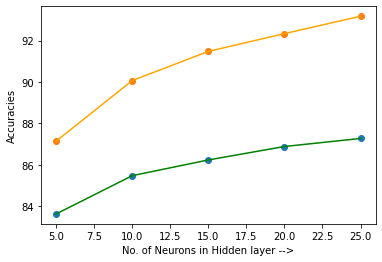

In [37]:
basic_network('fixed')

# C. Adaptive learning type

  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

classes : 10
layer no : 0 No of neurons : 5 No of weights : 785 (5, 785)
layer no : 1 No of neurons : 10 No of weights : 6 (10, 6)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [16:31<00:00,  1.51it/s]


Error : 11.329722458243644
No of total values Match : 60000
number of correct match : 50653
Accuracy:  84.42166666666667


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 8219
Accuracy:  82.19
classes : 10
layer no : 0 No of neurons : 10 No of weights : 785 (10, 785)
layer no : 1 No of neurons : 10 No of weights : 11 (10, 11)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [18:45<00:00,  1.33it/s]


Error : 8.703714167304069
No of total values Match : 60000
number of correct match : 52603
Accuracy:  87.67166666666667


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 8491
Accuracy:  84.91
classes : 10
layer no : 0 No of neurons : 15 No of weights : 785 (15, 785)
layer no : 1 No of neurons : 10 No of weights : 16 (10, 16)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [18:36<00:00,  1.34it/s]


Error : 7.330373614419109
No of total values Match : 60000
number of correct match : 53453
Accuracy:  89.08833333333334


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 8580
Accuracy:  85.8
classes : 10
layer no : 0 No of neurons : 20 No of weights : 785 (20, 785)
layer no : 1 No of neurons : 10 No of weights : 21 (10, 21)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [21:45<00:00,  1.15it/s]


Error : 7.597090322124601
No of total values Match : 60000
number of correct match : 53905
Accuracy:  89.84166666666667


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 8661
Accuracy:  86.61
classes : 10
layer no : 0 No of neurons : 25 No of weights : 785 (25, 785)
layer no : 1 No of neurons : 10 No of weights : 26 (10, 26)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [21:52<00:00,  1.14it/s]


Error : 6.742214916764054
No of total values Match : 60000
number of correct match : 54053
Accuracy:  90.08833333333334
No of total values Match : 10000
number of correct match : 8696
Accuracy:  86.96
Training Accuracies : [84.42, 87.67, 89.09, 89.84, 90.09]
Testing Accuracies : [82.19, 84.91, 85.8, 86.61, 86.96]
Time Taken : [992, 1125, 1116, 1306, 1312]


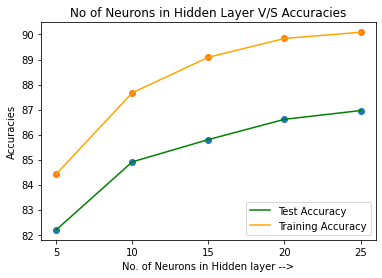

NameError: name 't' is not defined

In [72]:
basic_network('adaptive')

# D. Relu acitvation function and how it is different from sigmoid

In [110]:
def relu_network(learning_type='fixed'):

  hidden_layers = [5,10,15,20,25]
  training_accuracies = []
  test_accuracies = []
  time_taken = []
  for neurons in hidden_layers:
      t0 = time.time()
      layers = train([neurons], 100, X_train, Y_train, 1500, 'relu',0.1,learning_type)
      time_taken.append(round(time.time()-t0))
      training_accuracies.append(accuracy_(layers, X_train, Y_train, 'relu'))
      test_accuracies.append(accuracy_(layers, X_test, Y_test, 'relu'))
  
  print('Training Accuracies :', training_accuracies)
  print('Testing Accuracies :', test_accuracies)
  print('Time Taken :', time_taken)
  #plot accuracies
  plot_test_acc('No of Neurons in Hidden Layer V/S Accuracies','No. of Neurons in Hidden layer -->','Accuracies',hidden_layers,test_accuracies,training_accuracies)

  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

classes : 10
layer no : 0 No of neurons : 5 No of weights : 785 (5, 785)
layer no : 1 No of neurons : 10 No of weights : 6 (10, 6)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [16:17<00:00,  1.54it/s]


Error : 25.302147283768402
No of total values Match : 60000
number of correct match : 31884
Accuracy:  53.14


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 5208
Accuracy:  52.08
classes : 10
layer no : 0 No of neurons : 10 No of weights : 785 (10, 785)
layer no : 1 No of neurons : 10 No of weights : 11 (10, 11)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [17:48<00:00,  1.40it/s]


Error : 20.503284116993164
No of total values Match : 60000
number of correct match : 40437
Accuracy:  67.395
No of total values Match : 10000
number of correct match : 6592


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

Accuracy:  65.92
classes : 10
layer no : 0 No of neurons : 15 No of weights : 785 (15, 785)
layer no : 1 No of neurons : 10 No of weights : 16 (10, 16)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [16:28<00:00,  1.52it/s]


Error : 24.11693315960143
No of total values Match : 60000
number of correct match : 34946
Accuracy:  58.24333333333333


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 5695
Accuracy:  56.95
classes : 10
layer no : 0 No of neurons : 20 No of weights : 785 (20, 785)
layer no : 1 No of neurons : 10 No of weights : 21 (10, 21)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [20:00<00:00,  1.25it/s]


Error : 29.225837300405242
No of total values Match : 60000
number of correct match : 28985
Accuracy:  48.30833333333333


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 4727
Accuracy:  47.27
classes : 10
layer no : 0 No of neurons : 25 No of weights : 785 (25, 785)
layer no : 1 No of neurons : 10 No of weights : 26 (10, 26)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [22:25<00:00,  1.11it/s]


Error : 29.564096572449888
No of total values Match : 60000
number of correct match : 28428
Accuracy:  47.38
No of total values Match : 10000
number of correct match : 4586
Accuracy:  45.86
Training Accuracies : [53.14, 67.4, 58.24, 48.31, 47.38]
Testing Accuracies : [52.08, 65.92, 56.95, 47.27, 45.86]
Time Taken : [977, 1068, 989, 1200, 1346]


NameError: name 'title_text' is not defined

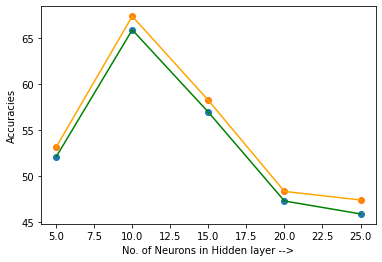

In [111]:
relu_network('adaptive')

In [23]:
print('Activation function : sigmoid')
layers = train([100,100], 100, X_train, Y_train, 1500, 'sigmoid',0.1,'adaptive')
accuracy_(layers, X_train, Y_train, 'sigmoid')
accuracy_(layers, X_test, Y_test, 'sigmoid')


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

Activation function : sigmoid
classes : 10
layer no : 0 No of neurons : 100 No of weights : 785 (100, 785)
layer no : 1 No of neurons : 100 No of weights : 101 (100, 101)
layer no : 2 No of neurons : 10 No of weights : 101 (10, 101)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [51:19<00:00,  2.05s/it]


Error : 6.026265831244133
No of total values Match : 60000
number of correct match : 55475
Accuracy:  92.45833333333333
No of total values Match : 10000
number of correct match : 8835
Accuracy:  88.35


88.35

# E. 5 hidden layers and 50 units per layer


In [112]:
def more_layers(learning_type='fixed'):

  hidden_layers = [50,50,50,50,50]
  training_accuracies = []
  test_accuracies = []
  time_taken = []
  for neurons in hidden_layers:
      t0 = time.time()
      layers = train([neurons], 100, X_train, Y_train, 1500, 'sigmoid',0.1,learning_type)
      time_taken.append(round(time.time()-t0))
      training_accuracies.append(accuracy_(layers, X_train, Y_train, 'sigmoid'))
      test_accuracies.append(accuracy_(layers, X_test, Y_test, 'sigmoid'))
  
  print('Training Accuracies :', training_accuracies)
  print('Testing Accuracies :', test_accuracies)
  print('Time Taken :', time_taken)
  #plot accuracies
  plot_test_acc('No of Neurons in Hidden Layer V/S Accuracies','No. of Neurons in Hidden layer -->','Accuracies',hidden_layers,test_accuracies,training_accuracies)

  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

classes : 10
layer no : 0 No of neurons : 50 No of weights : 785 (50, 785)
layer no : 1 No of neurons : 10 No of weights : 51 (10, 51)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [29:10<00:00,  1.17s/it]


Error : 6.346123310976623
No of total values Match : 60000
number of correct match : 54568
Accuracy:  90.94666666666667


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 8775
Accuracy:  87.75
classes : 10
layer no : 0 No of neurons : 50 No of weights : 785 (50, 785)
layer no : 1 No of neurons : 10 No of weights : 51 (10, 51)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [26:57<00:00,  1.08s/it]


Error : 6.780349537528832
No of total values Match : 60000
number of correct match : 54532
Accuracy:  90.88666666666667


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 8802
Accuracy:  88.02
classes : 10
layer no : 0 No of neurons : 50 No of weights : 785 (50, 785)
layer no : 1 No of neurons : 10 No of weights : 51 (10, 51)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [24:04<00:00,  1.04it/s]


Error : 6.821421751935156
No of total values Match : 60000
number of correct match : 54517
Accuracy:  90.86166666666666


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 8784
Accuracy:  87.84
classes : 10
layer no : 0 No of neurons : 50 No of weights : 785 (50, 785)
layer no : 1 No of neurons : 10 No of weights : 51 (10, 51)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [25:54<00:00,  1.04s/it]


Error : 6.839956716295603
No of total values Match : 60000
number of correct match : 54634
Accuracy:  91.05666666666667


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 8775
Accuracy:  87.75
classes : 10
layer no : 0 No of neurons : 50 No of weights : 785 (50, 785)
layer no : 1 No of neurons : 10 No of weights : 51 (10, 51)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [26:09<00:00,  1.05s/it]


Error : 6.526810489956394
No of total values Match : 60000
number of correct match : 54566
Accuracy:  90.94333333333333
No of total values Match : 10000
number of correct match : 8767
Accuracy:  87.67
Training Accuracies : [90.95, 90.89, 90.86, 91.06, 90.94]
Testing Accuracies : [87.75, 88.02, 87.84, 87.75, 87.67]
Time Taken : [1751, 1618, 1445, 1555, 1569]


NameError: name 'title_text' is not defined

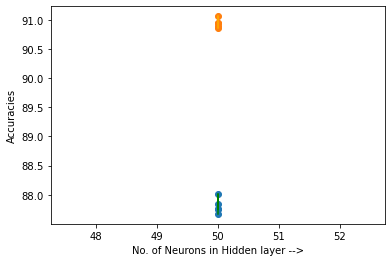

In [113]:
more_layers('adaptive')

In [114]:
def more_layers(learning_type='fixed'):

  hidden_layers = [50,50,50,50,50]
  training_accuracies = []
  test_accuracies = []
  time_taken = []
  for neurons in hidden_layers:
      t0 = time.time()
      layers = train([neurons], 100, X_train, Y_train, 1500, 'relu',0.1,learning_type)
      time_taken.append(round(time.time()-t0))
      training_accuracies.append(accuracy_(layers, X_train, Y_train, 'relu'))
      test_accuracies.append(accuracy_(layers, X_test, Y_test, 'relu'))
  
  print('Training Accuracies :', training_accuracies)
  print('Testing Accuracies :', test_accuracies)
  print('Time Taken :', time_taken)
  #plot accuracies
  plot_test_acc('No of Neurons in Hidden Layer V/S Accuracies','No. of Neurons in Hidden layer -->','Accuracies',hidden_layers,test_accuracies,training_accuracies)

  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

classes : 10
layer no : 0 No of neurons : 50 No of weights : 785 (50, 785)
layer no : 1 No of neurons : 10 No of weights : 51 (10, 51)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [28:18<00:00,  1.13s/it]


Error : 27.27908526687034
No of total values Match : 60000
number of correct match : 29432
Accuracy:  49.053333333333335
No of total values Match : 10000


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

number of correct match : 4800
Accuracy:  48.0
classes : 10
layer no : 0 No of neurons : 50 No of weights : 785 (50, 785)
layer no : 1 No of neurons : 10 No of weights : 51 (10, 51)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [47:12<00:00,  1.89s/it]


Error : 22.209761369031924
No of total values Match : 60000
number of correct match : 35023
Accuracy:  58.37166666666667


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 5706
Accuracy:  57.06
classes : 10
layer no : 0 No of neurons : 50 No of weights : 785 (50, 785)
layer no : 1 No of neurons : 10 No of weights : 51 (10, 51)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [42:31<00:00,  1.70s/it]


Error : 25.416564672296882
No of total values Match : 60000
number of correct match : 29472
Accuracy:  49.12


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 4838
Accuracy:  48.38
classes : 10
layer no : 0 No of neurons : 50 No of weights : 785 (50, 785)
layer no : 1 No of neurons : 10 No of weights : 51 (10, 51)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [33:35<00:00,  1.34s/it]


Error : 16.73170436193174
No of total values Match : 60000
number of correct match : 40443
Accuracy:  67.405


  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

No of total values Match : 10000
number of correct match : 6562
Accuracy:  65.62
classes : 10
layer no : 0 No of neurons : 50 No of weights : 785 (50, 785)
layer no : 1 No of neurons : 10 No of weights : 51 (10, 51)


100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [38:22<00:00,  1.54s/it]


Error : 32.154925692782925
No of total values Match : 60000
number of correct match : 23803
Accuracy:  39.67166666666667
No of total values Match : 10000
number of correct match : 3932
Accuracy:  39.32
Training Accuracies : [49.05, 58.37, 49.12, 67.4, 39.67]
Testing Accuracies : [48.0, 57.06, 48.38, 65.62, 39.32]
Time Taken : [1699, 2832, 2551, 2015, 2303]


NameError: name 'title_text' is not defined

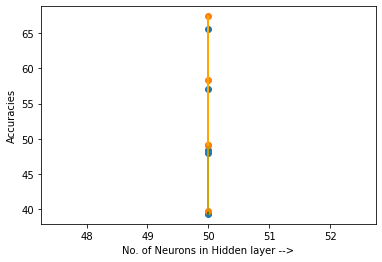

In [115]:
more_layers('adaptive')

# F. Binary Cross-entroy 

In [69]:
def compute_bce_cost(labels, predictions):
    """
    This function computes Binary Cross-Entropy(bce) Cost and returns the Cost and its
    derivative.
    This function uses the following Binary Cross-Entropy Cost defined as:
    => (1/m) * np.sum(-Y*np.log(P_hat) - (1-Y)*np.log(1-P_hat)
    """
    m = labels.shape[1]  # m -> number of examples in the batch
    cost = (1/m) * np.sum(-labels*np.log(predictions) - (1-labels)*np.log(predictions))
    cost = np.squeeze(cost)  # remove extraneous dimensions to give just a scalar (e.g. this turns [[17]] into 17)
    dP_hat = (1/m) * (-(labels/predictions) + ((labels)/(predictions)))
    return cost, dP_hat

In [70]:
def train_per_batch(layers, features, labels, af, lr, nt):
    #features is a subset of x
    #labels is subset of y
    batch_size = 100
    forward_prop(features, af, layers, batch_size) #forward propagation
    
    #get the prediction of output layer
    last_layer = len(layers) - 1
    last_layer_input = layers[last_layer]["net_input"]
    last_layer_weight = layers[last_layer]["weights"].T
    z = np.dot(last_layer_input,last_layer_weight)
# predictions = sigmoid(z)
    predictions = activation_fn(z,'sigmoid')
    #output of lastlayer
    #compute mean squared error
    error = compute_bce_cost(labels, predictions)
    #back propagate the error to update weights
    back_prop(labels, predictions, last_layer, layers, lr, af,batch_size )
    
    return error

In [71]:
def train(nodes_per_layer, batch_size, Y_train, train_labels, num_epochs, af, lr, learning_type='fixed',initial_weight=0.1):
    total_features = Y_train.shape[1] # total attributes
    total_classes = train_labels.shape[1] # total classes
    print('classes :',total_classes)
    layers = define_layers(nodes_per_layer, total_features, total_classes, batch_size,initial_weight)
    dataset_size = len(Y_train)
    n0 = 0.5 #initial point
    for j in tqdm(range(1,num_epochs+1)):
        if learning_type =='adaptive':
          lr = n0/np.sqrt(j) #condition to run adaptive network 
        i = 0
        while i+batch_size <= dataset_size :
            train_features_= Y_train[i:i+batch_size]
            train_labels_= train_labels[i:i+batch_size]
            error = train_per_batch(layers, train_features_,train_labels_ , af, lr, 2.0)
            i +=batch_size
    print('Error :',error) 
    return layers

In [72]:
print('Activation function : sigmoid')
layers = train([100,100], 100, X_train, Y_train, 1000, 'sigmoid',0.1,'adaptive')
accuracy_(layers, X_train, Y_train, 'sigmoid')
accuracy_(layers, X_test, Y_test, 'sigmoid')

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Activation function : sigmoid
classes : 10
layer no : 0 No of neurons : 100 No of weights : 785 (100, 785)
layer no : 1 No of neurons : 100 No of weights : 101 (100, 101)
layer no : 2 No of neurons : 10 No of weights : 101 (10, 101)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [37:00<00:00,  2.22s/it]


Error : (771.5373716250961, array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

88.15

In [89]:
print('Activation function : relu')
layers = train([100,100], 100, X_train, Y_train, 1000, 'relu',0.1,'adaptive')
accuracy_(layers, X_train, Y_train, 'relu')
accuracy_(layers, X_test, Y_test, 'relu')

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Activation function : relu
classes : 10
layer no : 0 No of neurons : 100 No of weights : 785 (100, 785)
layer no : 1 No of neurons : 100 No of weights : 101 (100, 101)
layer no : 2 No of neurons : 10 No of weights : 101 (10, 101)


<ipython-input-9-c9be39138402>:6: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))
<ipython-input-69-bcc220fcdc89>:9: RuntimeWarning: divide by zero encountered in log
  cost = (1/m) * np.sum(-labels*np.log(predictions) - (1-labels)*np.log(predictions))
<ipython-input-69-bcc220fcdc89>:9: RuntimeWarning: invalid value encountered in multiply
  cost = (1/m) * np.sum(-labels*np.log(predictions) - (1-labels)*np.log(predictions))
<ipython-input-69-bcc220fcdc89>:11: RuntimeWarning: invalid value encountered in true_divide
  dP_hat = (1/m) * (-(labels/predictions) + ((labels)/(predictions)))
100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:07:42<00:00,  4.06s/it]


Error : (nan, array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,

10.0

# G. MLP Classifier

In [50]:
def mlp_classifier(features,labels,epochs,lr,af,momentum_fn=0.9):
  mlp_clf = MLPClassifier((100,100),activation=af,solver='sgd',batch_size=100,learning_rate='invscaling',learning_rate_init=lr,shuffle=True,random_state=1, max_iter = epochs,momentum=momentum_fn)
  mlp_clf.fit(features,labels)
  return mlp_clf

In [53]:
mlp_clf = mlp_classifier(X_train ,Y_train ,1000,0.1,'logistic')

In [84]:
print('train accuracy:', mlp_clf.score(X_train, Y_train))
print('test accuracy:', mlp_clf.score(X_test, Y_test))

train accuracy: 0.7817666666666667
test accuracy: 0.7667


In [87]:
mlp_clf_relu = mlp_classifier(X_train ,Y_train,1000,0.1,'relu',0)

In [88]:
print('train accuracy:', mlp_clf_relu.score(X_train, Y_train))
print('test accuracy:', mlp_clf_relu.score(X_test, Y_test))

train accuracy: 0.7898666666666667
test accuracy: 0.7761
